In [6]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

name = "resnet_34"
joint = "hip" # hip, knee, ankle
ds = "val" # val, test

loss_data = np.load(f'data/arrays/loss_data_{name}_{joint}.npz')
image_dir = f"data/images/4_pre-proc3/{joint}"
landmarks_array = np.load(f"data/arrays/y_{ds}_{joint}.npy")
landmarks_pred_array = np.load(f"data/arrays/y_pred_{ds}_{joint}.npy")

vis = False

FileNotFoundError: [Errno 2] No such file or directory: 'data/arrays/loss_data_resnet_34_hip.npz'

### Plot training and validation loss

/var/tmp/pbs.9533156.pbs/ipykernel_3874025/2579584604.py:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10**5)


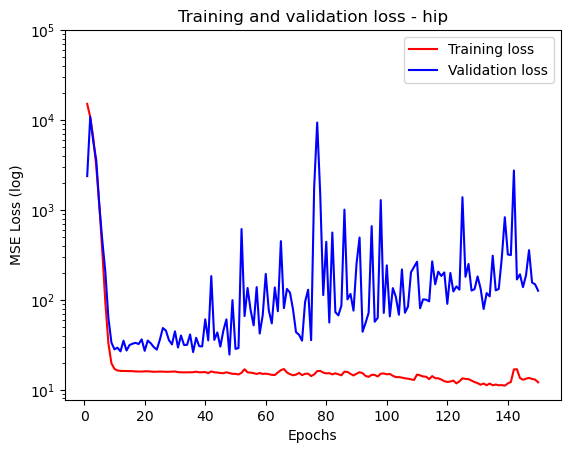

In [5]:
epochs = loss_data['epochs']
loss = loss_data['loss']
val_loss = loss_data['val_loss']

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.yscale('log')
plt.ylim(0, 10**5)
plt.title(f'Training and validation loss - {joint}')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss (log)')
plt.legend()
plt.show()

### Plot distance of prediction from ground truth

In [81]:
def create_mask(image_ref):
    """
    Create a mask with the same properties as the input image.

    Parameters:
    - image_ref (sitk.Image): The reference image to create the mask from.

    Returns:
    - mask (sitk.Image): The created mask with the same properties as the input image.
    """
    
    mask = sitk.Image(image_ref.GetSize(), sitk.sitkUInt8)
    mask.SetSpacing(image_ref.GetSpacing())
    mask.SetOrigin(image_ref.GetOrigin())
    mask.SetDirection(image_ref.GetDirection())
    
    return mask

def apply_landmarks(image, landmarks_pred_array, landmarks_array, image_index):
    """
    Set voxel value to 1 at each landmark using a NumPy array for landmark coordinates.

    Parameters:
    - image (sitk.Image): The input image data.
    - landmarks_pred_array (numpy.ndarray): The predicted landmarks array.
    - landmarks_array (numpy.ndarray): The annotated landmarks array.
    - image_index (int): The index of the image to process.

    Returns:
    - image (sitk.Image): The image with landmarks applied.
    """

    # Calculate the number of landmarks based on the array shape
    n_landmarks = landmarks_pred_array.shape[1] // 3

    # Extract the landmarks for the specified image
    image_landmarks_pred = landmarks_pred_array[image_index, :]
    image_landmarks = landmarks_array[image_index, :]
    
    for i in range(n_landmarks):
        # Each landmark has 3 consecutive values (x, y, z)
        start_idx = i * 3
        x, y, z = image_landmarks_pred[start_idx:start_idx + 3]

        # Round the coordinates to nearest integer
        x, y, z = round(x), round(y), round(z)
        landmark_coords = (x, y, z)

        try:
            # Attempt to set voxel value to 1
            image.SetPixel(landmark_coords, 1)
        except Exception as e:
            # Handle any error by skipping this landmark and printing a message
            print(f"Skipped applying landmark at coordinates {landmark_coords} due to error: {e}")

    return image

def binary_dilate(image):
    """
    Apply a Binary Dilation filter to make intensity 1 voxels become spheres.

    Parameters:
    - image (sitk.Image): The input image to be dilated.

    Returns:
    - dilated_image (sitk.Image): The dilated image.
    """

    # Create a Binary Dilation filter
    dilate_filter = sitk.BinaryDilateImageFilter()
    dilate_filter.SetKernelRadius(3)
    dilate_filter.SetKernelType(sitk.sitkBall)
    dilate_filter.SetForegroundValue(1)

    # Apply the dilation filter to the image
    dilated_image = dilate_filter.Execute(image)

    return dilated_image

def calculate_pred_error(landmarks_pred_array, landmarks_array, image_index, ):
    """
    Calculate the 3D prediction error and differences along each axis (x, y, z)
    between predicted and true landmark coordinates.
    
    Parameters:
    - pred_coords: (x, y, z) coordinates of the predicted landmark.
    - true_coord: (x, y, z) coordinates of the ground truth landmark.
    
    Returns:
    - error: The Euclidean distance between the predicted and true coordinates.
    - differences: A tuple containing the differences along each axis (dx, dy, dz).
    """

    # Calculate the number of landmarks based on the array shape
    n_landmarks = landmarks_pred_array.shape[1] // 3

    # Extract the landarks for the specified image
    image_landmarks_pred = landmarks_pred_array[image_index, :]
    image_landmarks = landmarks_array[image_index, :]
    
    # Temporary list for this image's distances
    landmarks_annot = []
    image_diff = []
    image_eu_dist = []
    for i in range(n_landmarks):
        # Each landmark has 3 consecutive values (x, y, z)
        start_idx = i * 3

        x, y, z = image_landmarks_pred[start_idx:start_idx + 3]
        x, y, z = round(x), round(y), round(z)
        pred_coords = (x, y, z)
        print(f"Predicted landmark {i+1}: {pred_coords}")

        x, y, z = image_landmarks[start_idx:start_idx + 3]
        x, y, z = round(x), round(y), round(z)
        true_coords = (x, y, z)
        print(f"Annotated landmark {i+1}: {true_coords}")
        landmarks_annot.append(true_coords)

        differences = np.array(pred_coords) - np.array(true_coords)
        error = np.sqrt(np.sum(differences ** 2))
        print(f"Differences of landmark prediction to ground truth {i+1} (x, y, z): {tuple(differences)}")
        print(f"Euclidean distance of landmark prediction {i+1}: {error}")
        
        # Append the distance for this landmark
        image_diff.append(differences)
        image_eu_dist.append(error)

        print("")
    
    return image_eu_dist, image_diff, landmarks_annot

In [82]:
image_index = 0
diff = []
eu_dist = []
landmarks = []

print(f"{joint} {ds} \n")

image_names = sorted(os.listdir(image_dir))
for image_name in image_names:
    if image_name.endswith('.nii.gz') and image_index < landmarks_array.shape[0]:
        
        print(f"Image {image_name}")
        print("--------------------------------")

        # Load image
        image = sitk.ReadImage(os.path.join(image_dir, image_name))
        
        # Calculate prediction error
        image_eu_dist, image_differences, landmarks_annot = calculate_pred_error(landmarks_pred_array, landmarks_array, image_index)
        diff.append(image_differences)
        eu_dist.append(image_eu_dist)
        landmarks.append(landmarks_annot)
        
        ## Visualisation
        if vis:
            # Create mask
            mask = create_mask(image)

            # Apply landmarks prediction to mask
            mask_annot = apply_landmarks(mask, landmarks_pred_array, landmarks_array, image_index)
        
            # Apply binary dilation to visualise landmarks 
            mask_dilated = binary_dilate(mask_annot)
        
            # Save image
            if not os.path.exists(os.path.join(image_dir, "mask_pred")):
                os.makedirs(os.path.join(image_dir, "mask_pred"))
            sitk.WriteImage(mask_dilated, os.path.join(image_dir, "mask_pred", image_name[:-7] + f"_mask_pred_{joint}.nii.gz"))
        
        image_index+=1
        print("")

# Save arrays
eu_dist_arr = np.array(eu_dist)
diff_arr = np.array(diff)
landmarks_arr = np.array(landmarks)

np.save(f"data/arrays/eu_dist_{ds}_{joint}.npy", eu_dist_arr)
np.save(f"data/arrays/differences_{ds}_{joint}.npy", diff_arr)
np.save(f"data/arrays/landmarks_{ds}_{joint}.npy", landmarks)

ankle val
Image lleg_001_20100125b_ankle.nii.gz, index 0:
--------------------------------
Predicted landmark 1: (117, 118, 121)
Annotated landmark 1: (128, 130, 156)
Differences of landmark prediction to ground truth 1 (x, y, z): (-11, -12, -35)
Euclidean distance of landmark prediction 1: 38.600518131237564

Predicted landmark 2: (120, 117, 107)
Annotated landmark 2: (129, 126, 100)
Differences of landmark prediction to ground truth 2 (x, y, z): (-9, -9, 7)
Euclidean distance of landmark prediction 2: 14.52583904633395


Image lleg_003_20100305b_ankle.nii.gz, index 1:
--------------------------------
Predicted landmark 1: (119, 121, 124)
Annotated landmark 1: (128, 130, 152)
Differences of landmark prediction to ground truth 1 (x, y, z): (-9, -9, -28)
Euclidean distance of landmark prediction 1: 30.757112998459398

Predicted landmark 2: (123, 120, 110)
Annotated landmark 2: (129, 126, 104)
Differences of landmark prediction to ground truth 2 (x, y, z): (-6, -6, 6)
Euclidean distance 